In [3]:
# This lets us refresh changes from other .py files without having to restart the notebook
%load_ext autoreload 
%autoreload 2

In [1]:
import torch
from torch import nn, utils
import torchvision as tv
import torchvision.transforms.v2 as v2
from blocks import *
from models import *
from utils import validateModelIO, getNormalizedTransform, showDatasetSamples, profileModel, getNormalizedTransforms, determinsticSplitFullDataset

from trainableModel import TrainingParameters, TrainableModel
import torchinfo
from dataLoading import CIFAR10Dataset
from transforms import *

import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


Using device: cuda
Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
torch.Size([256, 32, 32, 32])
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([256, 32, 32, 32])
ReLU()
torch.Size([256, 32, 32, 32])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([256, 32, 16, 16])
BranchBlock(
  (activation): ReLU()
  (inputNorm): Sequential(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
  )
  (branches): ModuleList(
    (0-2): 3 x DoubleEncodeBottleneckBlock2(
      (activation): ReLU()
      (inputNorm): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (encode1): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )

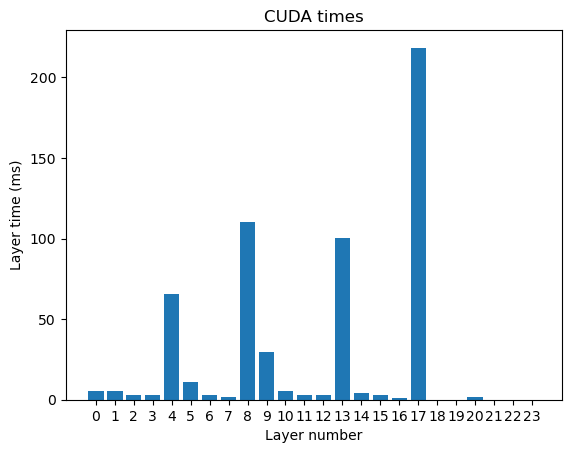

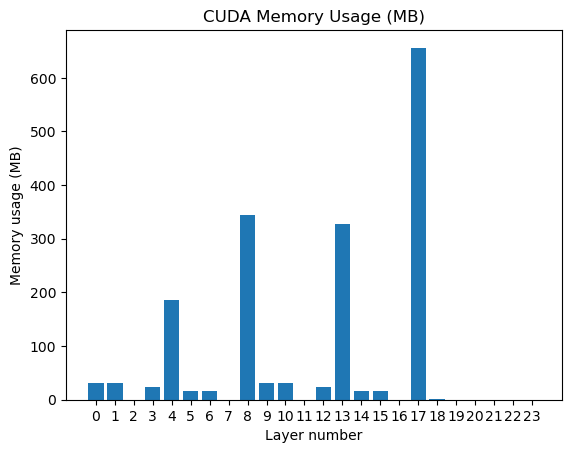

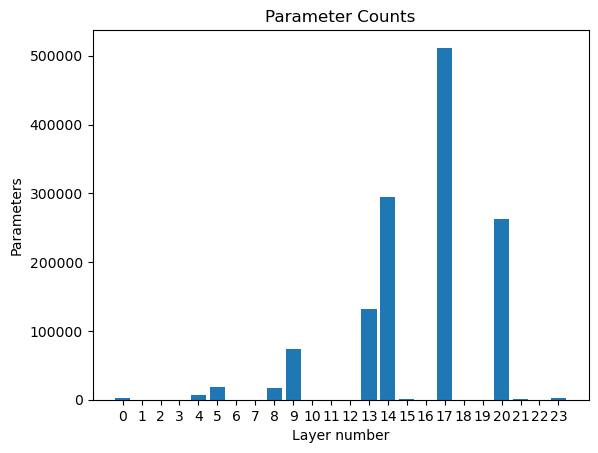

In [11]:
model = highwayResidualv2 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    HighwayBlock(in_channels=32, highwaySequence=nn.Sequential(
        *[ResidualBlock(channelCount=32, activation=nn.ReLU()) for _ in range(3)]
    )),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),

    HighwayBlock(in_channels=64, highwaySequence=nn.Sequential(
        *[ResidualBlock(channelCount=64, activation=nn.ReLU()) for _ in range(3)]
    )),
    
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    HighwayBlock(in_channels=128, highwaySequence=nn.Sequential(
        *[ResidualBlock(channelCount=128, activation=nn.ReLU()) for _ in range(6)]
    )),
    
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(),
    
    HighwayBlock(in_channels=256, highwaySequence=nn.Sequential(
        *[ResidualBlock(channelCount=256, activation=nn.ReLU()) for _ in range(6)]
    )),
    
    nn.AvgPool2d(kernel_size=4, stride=4, padding=0),
    
    nn.Flatten(),
    
    nn.Linear(in_features=256, out_features=64),
    nn.LayerNorm(normalized_shape=64),
    nn.ReLU(),
    
    nn.Linear(in_features=64, out_features=10)
)

batchSize = 256
input_size = (batchSize, 3, 32, 32)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = model.to(device)

dummy_input = torch.randn(input_size, device=device, dtype=torch.float)

output = dummy_input
for layer in model.children():
    print(layer)
    output = layer(output)
    print(output.size())

# output = model(dummy_input)
assert output.size() == (batchSize, 10), f"Expected output size ({batchSize}, 10), got {output.size()}!"

summaryObject = torchinfo.summary(model=model, input_size=input_size, device=device, mode='train', depth=20, verbose=0)
print(summaryObject)

profileModel(model=model, input_size=input_size)

MAX VALUE: 1.0
MIN VALUE: 0.0


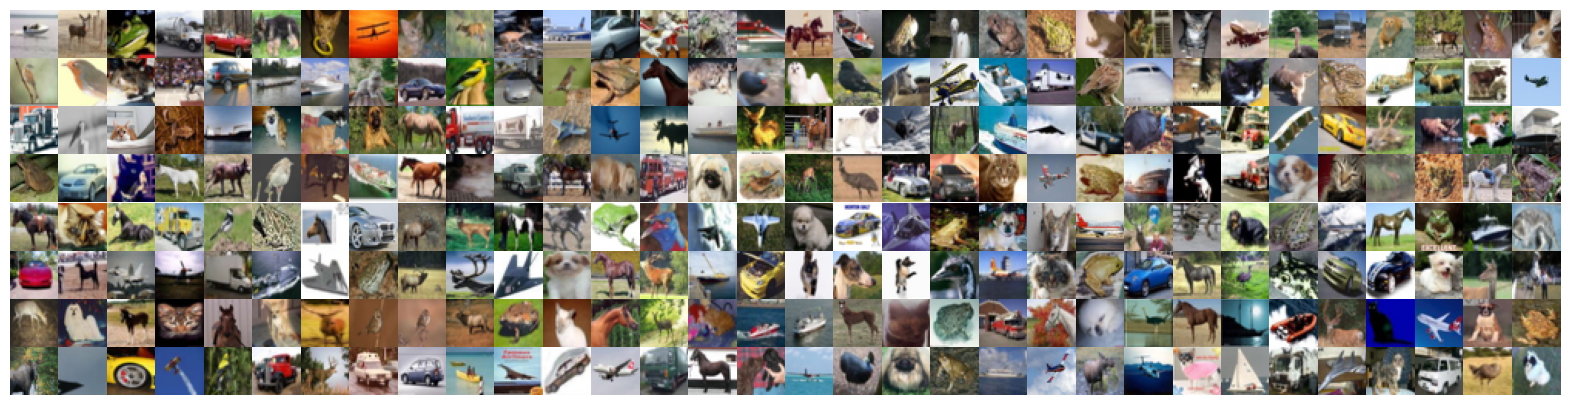

ship	deer	frog	truck	automobile	dog	dog	airplane	cat	deer	deer	airplane	automobile	horse	frog	ship	horse	ship	frog	bird	frog	frog	frog	cat	cat	airplane	bird	truck	cat	deer	frog	deer	
8	4	6	9	1	5	5	0	3	4	4	0	1	7	6	8	7	8	6	2	6	6	6	3	3	0	2	9	3	4	6	4	MAX VALUE: 1.0
MIN VALUE: 0.0


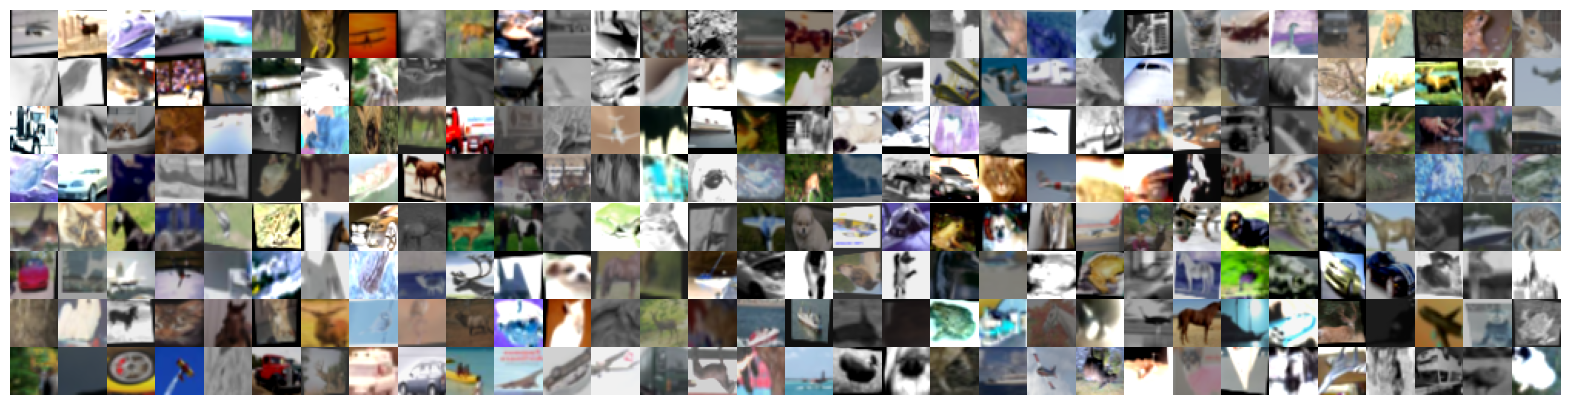

ship	deer	frog	truck	automobile	dog	dog	airplane	cat	deer	deer	airplane	automobile	horse	frog	ship	horse	ship	frog	bird	frog	frog	frog	cat	cat	airplane	bird	truck	cat	deer	frog	deer	
8	4	6	9	1	5	5	0	3	4	4	0	1	7	6	8	7	8	6	2	6	6	6	3	3	0	2	9	3	4	6	4	Normalizing...
tensor([0.4647, 0.4552, 0.4398])
tensor([0.1819, 0.1787, 0.1771])
Done normalizing!
normalizedTrainTransform: Compose(
      RandomPerspective(p=0.5, distortion_scale=0.3, interpolation=InterpolationMode.BILINEAR, fill=0)
      RandomGrayscale(p=0.2)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.2)
      RandomInvert(p=0.2)
      RandomResizedCrop(size=(32, 32), scale=(0.3, 1), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
      ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.6, 1.4))
      Normalize(mean=[tensor(0.4647), tensor(0.4552), tensor(0.4398)], std=[tensor(0.1819), tensor(0.1787), tensor(0.1771)], inplace=False)
)
normalizedValTestTran

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

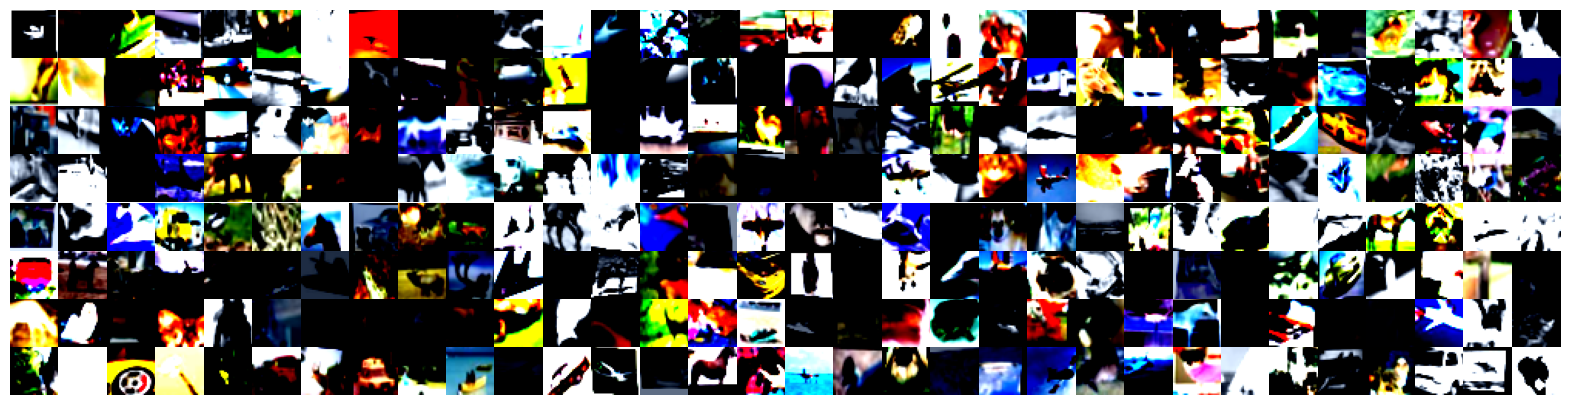

ship	deer	frog	truck	automobile	dog	dog	airplane	cat	deer	deer	airplane	automobile	horse	frog	ship	horse	ship	frog	bird	frog	frog	frog	cat	cat	airplane	bird	truck	cat	deer	frog	deer	
8	4	6	9	1	5	5	0	3	4	4	0	1	7	6	8	7	8	6	2	6	6	6	3	3	0	2	9	3	4	6	4	

In [2]:

trainTransform = v2.Compose([
    v2.RandomPerspective(distortion_scale=0.3, p=0.5),
    v2.RandomGrayscale(p=0.2),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.2),
    v2.RandomInvert(p=0.2),
    v2.RandomResizedCrop(size=(32, 32), scale=(0.3, 1), antialias=True),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.4),
])
valTestTransform = NONE

# fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=None)

# modelParameters = TrainingParameters(fullDataset=fullDataset, trainTransform=trainTransform, valTestTransform=None, 
#                                   trainValTestSplit=[0.8, 0.1, 0.1], epochs=10, warmupEpochs=5, batch_size=256,
#                                   lr=1e-2, momentum=0.8)

dataLoaderParameters = {
    'num_workers': 2,
    'pin_memory': True,
    'prefetch_factor': 4
}

# trainLoader = utils.data.DataLoader(modelParameters.trainDataset, batch_size=modelParameters.batch_size, shuffle=True, **dataLoaderParameters)

# showDatasetSamples(trainLoader, fullDataset)

# print(f'Normalizing...', flush=True)
# normalizedTrainTransform, normalizedValTestTransform = getNormalizedTransforms(fullDataset=fullDataset, trainTransform=trainTransform, valTestTransform=valTestTransform, showSamples=False,
#     customNormalization=False)
# print(f'Done normalizing!', flush=True)



# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=None)
trainDataset, validationDataset, testDataset = determinsticSplitFullDataset(fullDataset=fullDataset, trainValTestSplit=[0.8, 0.1, 0.1])

trainLoader = utils.data.DataLoader(trainDataset, batch_size=256, shuffle=False, **dataLoaderParameters)
showDatasetSamples(trainLoader, fullDataset)

tempFull = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=trainTransform)
transformedTrainDataset, _, _ = determinsticSplitFullDataset(fullDataset=tempFull, trainValTestSplit=[0.8, 0.1, 0.1])
transformedTrainLoader = utils.data.DataLoader(transformedTrainDataset, batch_size=256, shuffle=False, **dataLoaderParameters)

showDatasetSamples(transformedTrainLoader, tempFull)


print(f'Normalizing...', flush=True)
normalizedTrainTransform, normalizedValTestTransform = getNormalizedTransforms(fullDataset=fullDataset, trainTransform=trainTransform, valTestTransform=valTestTransform, showSamples=False,
    customNormalization=None)
print(f'Done normalizing!', flush=True)

print(f'normalizedTrainTransform: {normalizedTrainTransform}')
print(f'normalizedValTestTransform: {normalizedValTestTransform}')

modelParams = TrainingParameters(fullDataset=fullDataset, trainTransform=normalizedTrainTransform, valTestTransform=normalizedValTestTransform, 
                                trainValTestSplit=[0.8, 0.1, 0.1], epochs=1, warmupEpochs=5, batch_size=256,
                                lr=1, momentum=1, weight_decay=1, nesterov=True, plateuPatience=2, plateuFactor=0.5)

trainLoader = utils.data.DataLoader(modelParams.trainDataset, batch_size=modelParams.batch_size, shuffle=False, **dataLoaderParameters)

showDatasetSamples(trainLoader, fullDataset)


# PATH = os.path.normpath(r"C:\Users\Nicholas\Documents\GRADUATE OFFLINE\CS 444\CS-444-Final-Project\models\HighwayNetv3-0_Epoch100_Batch2048_LR0.1_Momentum0.8")
# loadedModel = torch.load(PATH)

# model = highwaynetv3
# model.load_state_dict(loadedModel)

# trainableModel = TrainableModel('ZTestnet', model, modelParameters)
# trainableModel.train()